In [286]:
##importing everything
import sys
#if the device the code is being ran on doesn't contain any of the librarys listed underneath
#please use the following command to pip install them
#!{sys.executable} -m pip install {library}
import pandas as pd
import numpy as np
######
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
######
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
######
import matplotlib.pyplot as plt
import datetime
###################################
#PART 1
w_df = pd.read_csv('weather_data.csv')
# w_df.info()
e_df = pd.read_csv('energy_data.csv')
# e_df.info()

#convert to datetime object
#first convert the time from int to a readable date
##################
for ind in w_df.index:
    w_df["time"][ind] = datetime.datetime.fromtimestamp(w_df["time"][ind])
w_df["time"] = pd.to_datetime(w_df["time"]) 
# print(w_df)
#only want the time for the year 2014
w_df = w_df.loc[(w_df['time'] >= datetime.datetime.fromtimestamp(1388549000))]
# temp = w_df.groupby(pd.Grouper(key='time', freq='1D')).sum()

##################
e_df['time'] = pd.to_datetime(e_df['Date & Time'])

#calculate sum per day
sum_of_use = e_df.groupby(pd.Grouper(key = 'time', freq = '1D')).sum()
# sum_use_col = sum_of_use["use [kW]"]
# w_df['use [kW]'] = sum_of_use['use [kW]'].values
#merge the data together
merged_data = pd.merge(w_df, sum_of_use, on = 'time')
print("MERGED:\n")
print(merged_data)


MERGED:

     temperature                 icon  humidity  visibility        summary  \
0          20.31          clear-night      0.47       10.00          Clear   
1          19.92          clear-night      0.76        5.44          Clear   
2           4.68                 snow      0.78        1.19     Light Snow   
3          -7.54          clear-night      0.75        9.93          Clear   
4          16.20          clear-night      0.61        9.97          Clear   
..           ...                  ...       ...         ...            ...   
360        27.75          clear-night      0.87        7.40          Clear   
361        41.70  partly-cloudy-night      0.72        9.89  Partly Cloudy   
362        35.44          clear-night      0.59       10.00          Clear   
363        25.77          clear-night      0.53       10.00          Clear   
364        14.55          clear-night      0.64       10.00          Clear   

     pressure  windSpeed  cloudCover       time  windB

C:\Users\jhxia\AppData\Local\Temp\ipykernel_24168\1901021199.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_df["time"][ind] = datetime.datetime.fromtimestamp(w_df["time"][ind])


In [287]:
###################################
#PART 2
#training using all the days in the year 2014 apart from december
train_data = merged_data[merged_data["time"].dt.month != 12]
#testing data is using the month of december in 2014
test_data = merged_data[merged_data["time"].dt.month == 12]

In [288]:
###################################
#PART 3
#drop the 'use [kW]', 'icon', and 'summary' columns from test data
test_data_drop = test_data.drop(['use [kW]', 'icon', 'summary'], axis = 1)
#do similar with train data
train_data_drop = train_data.drop(['icon', 'summary'], axis = 1)
#train the linear regression model
x_train = train_data_drop.drop(['time', 'use [kW]'], axis = 1).fillna(0)
y_train = train_data_drop['use [kW]'].fillna(0)
reg = LinearRegression().fit(x_train, y_train)

#predict energy usage for december using weather data
x_test = test_data_drop.drop('time', axis = 1).fillna(0)
y_pred = reg.predict(x_test)
#How well/badly does the model work?
#the model works very well as after comparing the predicted and expected results
#the values are extremely similar and that can be seen with the RMSE value below
#calculate RMSE of the model
y_true = test_data['use [kW]']
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: ", rmse)

#generate csv dump of predicted values
pred_df = pd.DataFrame({'time': test_data['time'], 'predicted_value': y_pred})
pred_df.to_csv('cse351_hw2_xia_junhao_113196003_linear_regression.csv', index = False)

RMSE:  1.0739390951000383e-13


In [289]:
###################################
#PART 4
#create avg_temp dataframe and find average temperature for each day
avg_temp = w_df.groupby(pd.Grouper(key = 'time', freq = '1D')).mean()
avg_temp['temperature_category'] = avg_temp['temperature'].apply(lambda x: 1 if x >= 35 else 0)
#training using all the days in the year 2014 apart from december
train_data = avg_temp[avg_temp.index.month != 12]
#testing data is using the month of december in 2014
test_data = avg_temp[avg_temp.index.month == 12]
# print(avg_temp)
#split the data
x_train, x_test, y_train, y_test = train_test_split(avg_temp.drop(['temperature_category'], axis=1),
                                                    avg_temp['temperature_category'], test_size=0.2, random_state=42)

#train the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

#evaluate the model
y_pred = lr_model.predict(x_test)
f1 = f1_score(y_test, y_pred)
print("F1 Score of:", f1)

#generate csv dump of temperature_category
pred_df = pd.DataFrame({'time': avg_temp.index, 'temperature_category': avg_temp['temperature_category']})
pred_df.to_csv('cse351_hw2_xia_junhao_113196003_logistic_regression.csv', index = False)


F1 Score of: 0.9772727272727273


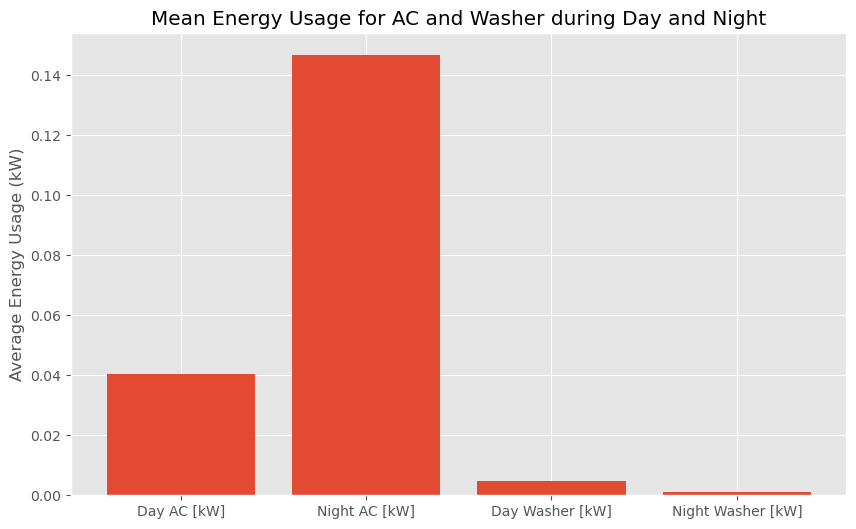

In [290]:
######################################
#PART 5
e_df['Date & Time'] = pd.to_datetime(e_df['Date & Time'])
#set time as index for dataframe
e_df.set_index('Date & Time', inplace=True)
#select the 2 devices
device1 = 'AC [kW]'
device2 = 'Washer [kW]'
devices_df = e_df[[device1, device2]]
# print(devices_df)
#split the devices dataframe into two parts - day and night
day_devices_df = devices_df.between_time('06:00:00', '18:59:59')
night_devices_df = devices_df.between_time('19:00:00', '05:59:59')
#calculate the mean energy usage for each device during the day and night
mean_day_energy_usage = day_devices_df.mean()
mean_night_energy_usage = night_devices_df.mean()
# print(mean_day_energy_usage)
# print(mean_night_energy_usage)
#set the style of the plot
plt.style.use('ggplot')

#plot the mean energy usage for the two devices during the day and night
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(['Day ' + device1, 'Night ' + device1, 'Day ' + device2, 'Night ' + device2], 
       [mean_day_energy_usage[0], mean_night_energy_usage[0], mean_day_energy_usage[1], mean_night_energy_usage[1]])
ax.set_title('Mean Energy Usage for AC and Washer during Day and Night')
ax.set_ylabel('Average Energy Usage (kW)')
plt.show()
#The graph plotted shows that, on average, AC usage tends to spike during the night
#compared to the day. Another relationship shown would be how the dishwasher uses
#more kw during the day on average. This also shows the comparision of energy
#usage between the AC and Washer.